# TP2 - Regression

Mục đích TP này : dự đoán một dải liên tục có dạng số (khác với TP1 là dự đoán dạng categorical (bệnh hay không bệnh))

In [56]:
# Check the directory now where i'm working
import os
print("Working directory:", os.getcwd())

Working directory: c:\Users\KTANG\Downloads\Python\Learn DS\TPs\TP2 - Regression


### ML Pipeline

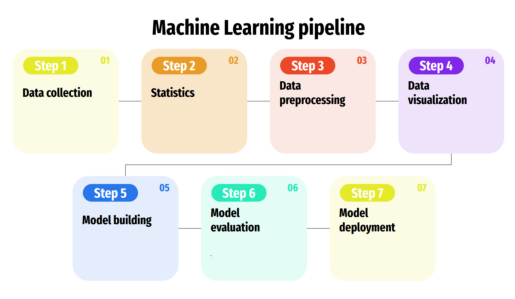

In [57]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(filename):
    img = mpimg.imread(filename)
    plt.imshow(img)
    plt.axis('off')  # Ẩn trục
    plt.show()

# Gọi hàm
show_image("../ML_Pipeline.png")

### B1 : Data collection : phải đi làm mới có (bỏ qua)
### Bước giữa B1 và B2 : Importing data

In [58]:
import pandas as pd

df = pd.read_csv("StudentScore.xls")
df #hoặc ghi "print(df)" hoặc df.info

# Ở đây có ba cột số là điểm toán, điểm văn, điểm viết và ta có thể chọn một trong ba cột này làm target
# hai cột còn lại sẽ tự động thành numerical feature
# Ở đây, ta chọn cột điểm toán làm target

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


### Có một cách để gộp B2+B4 vào một câu lệnh dựa vào thư viện "ydata-profiling" để có một report hoàn chỉnh về B2+B4

In [59]:
# from ydata_profiling import ProfileReport

# profile = ProfileReport(df, title="TP2 - Regression - Student Score Report")
# profile.to_file("TP2_Report.html")

#Xài xong thì comment nó lại để nó chạy một lần thôi là đủ rồi vì nó cũng chỉ cho ta coi dữ liệu lúc đầu chưa xử lý thôi

![image.png](Report_correlation.png)

Trong file report trên phần `Correlations` (hình trên), cần lưu ý rằng khi trong dataset có cả dữ liệu dạng numerical và cả dạng categorical thì chỉ quan tâm đến correlation giữa các cột giá trị dạng numerical thôi vì file report này sẽ tự động số hóa các giá trị categorical (số hóa theo kiểu theo thứ tự alphabet rồi đưa về dạng số) nên correlation của các cột giá trị dạng categorical không còn chính xác nữa.

Vậy các giá trị correlation của các cột categorical sẽ bỏ qua mà chỉ quan tâm correlation giữa các cột giá trị dạng numerical

In [60]:
# Vậy để dễ xem thì ta code thẳng để xem correlation giữa 3 cột numerical trong dataset

correlations = df.corr(numeric_only=True)
# correlations = df[["math score", "reading score", "writing score"]].corr()
print(correlations)

               math score  reading score  writing score
math score       1.000000       0.817580       0.802642
reading score    0.817580       1.000000       0.954598
writing score    0.802642       0.954598       1.000000


*Nhận xét 1 :* Nhìn vào các hệ số tương quan, ta thấy hai feature `reading score` và `writing` score có hệ số tương quan cao so với `target` => **CHỌN MÔ HÌNH TUYẾN TÍNH**
- Điểm mạnh của các mô hình tuyến tính :  đơn giản, nhỏ, nhẹ, chạy nhanh, có độ giải thích cao và phù hợp với các bộ dataset có hệ số tương quan cao giữa các features và target nếu cả target và feature đó đều là dạng numerical

*Nhận xét 2 :* Xét các features dạng numerical nhưng không có nghĩa là sẽ bỏ các features dạng categorical hay một feature bất kì đi
- Chỉ bỏ các feature đi khi biết chắc chắn rằng feature đó không ảnh hưởng gì đến mô hình đang xây dựng (dựa vào domain knowledge)

*Nhận xét 3 :* Khi đã biết trong một vài features có outliers (vd trong bài này có cột math score,...), khoan hẳn bỏ mà cứ xây dựng mô hình rồi sau đó loại bỏ outliers của features đó rồi chạy lại để xem performance của mô hình tăng như thế nào
- Vì trong thực tế, nhiều khi loại bỏ outliers có thể làm giảm performance của mô hình => đầu tiên cứ xây dựng mô hình cơ bản đã, sau đó áp dụng các kĩ thuật sau.
- Loại bỏ outliers (bước 2 trong 5 bước tiền xử lý dữ liệu) ko làm hoặc làm sau khi xây dựng mô hình cũng được, còn các bước còn lại tiền xử lý dữ liệu thì lúc nào cũng phải có

### Bước giữa bước B2+B4(Bước xem dữ liệu) và B3(Bước tiền xử lý dữ liệu):

Là bước chia dữ liệu theo :
- Phần A: theo chiều dọc (theo cột), tức là chia các cột X (các cột feature) với cột Y (cột target)
- Phần B: theo chiều ngang, tức là chia datasets thành 3 dataset con gồm bộ train, bộ validation và bộ test theo tỷ lệ tùy chọn (8-1-1, 9-0.5-0.5, 6-2-2)


Phần A

In [61]:
# Xác định target
target = "math score"

# dùng lệnh drop() trong pandas để xóa hàng (đưa chỉ số vào rồi thêm lệnh axis=0) 
# hoặc cột (đưa tên cột vào rồi thêm lệnh axis=1)
# Mục tiêu: Tách các cột X (các cột features) ra
x = df.drop(target, axis=1)

#Mục tiêu: Tách cột Y
y = df[target]

Phần B

In [62]:
from sklearn.model_selection import train_test_split, GridSearchCV
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

x_train


,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score
29,female,group D,master's degree,standard,none,70,75
535,female,group C,bachelor's degree,free/reduced,completed,83,83
695,female,group D,some college,free/reduced,none,89,86
557,male,group C,master's degree,free/reduced,none,67,66
836,male,group E,high school,standard,none,64,57
...,...,...,...,...,...,...,...
106,female,group D,master's degree,standard,none,100,100
270,male,group C,bachelor's degree,standard,none,63,61
860,female,group C,associate's degree,standard,none,62,53
435,male,group C,some college,free/reduced,completed,48,53


### Bước 3 : Tiền xử lý dữ liệu
![image.png](../Preprocessing_Pipeline.png)

#### B3.0 : Dùng fit(), transform(), fit_transform() để áp dụng thay đổi cho các thay đổi dữ liệu trong bước 3 tiền xử lý dữ liệu
Lưu ý trong các class lquan đến xử lý dữ liệu trong scikit learn (cả bước preprocessing hay modeling), có 3 thứ hay dùng là **fit()**, **transform()**, **fit_transform()**. Các hàm này được sử dụng cho nhiều mục đích, bao gồm việc chuyển đổi đặc trưng (feature transformation) hoặc xử lý dữ liệu (data preprocessing)

1.  *fit()* : Mục đích của hàm fit() là để tính toán các tham số cần thiết từ dữ liệu mà không thực hiện bất kỳ chuyển đổi nào trên dữ liệu đó. ***fit()*thường chỉ được thực hiện trên dữ liệu huấn luyện (training data)**
    *   Ví dụ :
        *   Đối với `StandardScaler`, hàm *fit()* sẽ tính toán giá trị trung bình (mean) và độ lệch chuẩn (standard deviation) của các đặc trưng trên tập dữ liệu đầu vào
        *   Đối với `MinMaxScaler`, hàm *fit()* sẽ tính toán giá trị nhỏ nhất (min) và giá trị lớn nhất (max) của các đặc trưng
        *   ví dụ khác khi đối với `SimpleImputer` (dùng để điền giá trị thiếu), hàm fit() sẽ tính toán giá trị trung bình (hoặc trung vị, mode) của cột để điền vào các giá trị thiếu

2.  *transform()* : dùng để áp dụng các thông số/các phép chuyển đổi đã được tính bởi hàm *fit()* vào các feature => Nó sẽ thay đổi định dạng của dữ liệu đầu vào
    *   **Được sử dụng cho dữ liệu huấn luyện (sau khi đã fit()) và dữ liệu kiểm tra (test data) hoặc dữ liệu mới** => Khi sử dụng cho bộ train, phải gọi fit trước để sử dụng transform còn khi sử dụng cho bộ test thì sử dụng trực tiếp transform() luôn chứ không được sử dụng fit()
    *   Ví dụ :
        *   Sau khi `StandardScaler` đã fit() và tính được mean và standard deviation, hàm transform() sẽ sử dụng các giá trị này để chuẩn hóa dữ liệu (trừ đi mean và chia cho standard deviation)
        *   Tương tự, `MinMaxScaler` sẽ sử dụng min và max đã fit() để chuẩn hóa dữ liệu về phạm vi từ 0 đến 1
    *   Điều cực kỳ quan trọng: Khi áp dụng cho dữ liệu kiểm tra hoặc dữ liệu mới, bạn chỉ sử dụng hàm transform() với cùng đối tượng "scaler" đã được fit() trên dữ liệu huấn luyện. Điều này đảm bảo rằng dữ liệu kiểm tra được chuyển đổi nhất quán với dữ liệu huấn luyện và ngăn chặn hiện tượng rò rỉ dữ liệu (data leakage) hoặc overfitting

3.  *fit_transform()* : một kết hợp của cả fit() và transform() mà sẽ vừa tính toán các tham số cần thiết, vừa áp dụng phép chuyển đổi dữ liệu ngay lập tức
    *   Hàm này thường được sử dụng trên dữ liệu huấn luyện để thực hiện cả hai bước một cách hiệu quả
    *   Ví dụ, khi bạn muốn chuẩn hóa dữ liệu huấn luyện bằng StandardScaler, bạn có thể gọi scaler.fit_transform(X_train) để vừa tính mean/std vừa áp dụng chuyển đổi
    
#### B3.1. Xử lý missing và invalid values

 - Nếu dữ liệu missing hay invalid dưới 5% (hoặc ngưỡng cho phép) thì `drop` luôn
 - Nếu không, thì hoặc dùng thẳng `MissForest` (điền tự động bằng 0 hoặc mean mà không thay đổi distribution) hoặc cách bình thường rằng thay thế bằng mean hoặc median (dùng hàm `SimpleImputer` trong sklearn) 
    *   Khi mới học, ta làm `SimpleImputer` để hiểu

In [63]:
# from sklearn.impute import SimpleImputer

# imputer = SimpleImputer(strategy="median") #dùng thay bằng median để đỡ bị (gần như không bị) ảnh hưởng bởi outliers

# x_train[["reading score", "writing score"]] = imputer.fit_transform(x_train[["reading score", "writing score"]])

# Lưu ý rằng, với bộ datasets hiện tại vì các dòng này không có ý nghĩa gì cả vì bộ dataset này cleaned (ko có missing hay invalid values)
# Nhưng để có một script tổng quát có thể dùng lại thì ta cứ để bước này vào

#### B3.3 : Data scaling 

**Ta bắt đầu với việc chuyển đổi các features số**

Lý thuyết cụ thể coi phần này TP1 - Classification

Tóm tắt ngắn gọn:

* **Dùng `MinMaxScaler`** khi:

  * Dữ liệu **phân bố không chuẩn** (còn gọi là không phải PP chuẩn (PP Gaussian))
  * Muốn đưa dữ liệu về **\[0, 1]**
  * Đặc biệt phù hợp cho **mô hình nhạy với scale** như *KNN*, *SVM*, *Neural Networks*

* **Dùng `StandardScaler`** khi:

  * Dữ liệu có **phân phối chuẩn** (xấp xỉ Gaussian)
  * Muốn giữ lại **thông tin về phân phối gốc** (mean = 0, std = 1)
  * Thường dùng cho **hầu hết thuật toán tuyến tính** như *Logistic Regression*, *Linear Regression*, *PCA*

**Mẹo**: Nếu không chắc, bắt đầu với `StandardScaler`, nhưng dùng `MinMaxScaler` cho các mô hình nhạy cảm với khoảng cách.


In [64]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# x_train[["reading score", "writing score"]] = scaler.fit_transform(x_train[["reading score", "writing score"]])
# x_train[["reading score", "writing score"]]

#### Nhận xét 


Giả sử sau 2 bước trên mà còn các bước tiền ửu lý dữ liệu khác thì cũng làm y như vậy, cad ta sẽ gọi mô hình đó ra rồi lại `fit_transform()` với bộ train rồi `transform()`với bộ test. Đại ý thì cách chúng ta xử lý nó đang giống hình bên dưới

![image.png](pipeline_preprocessing_not_optimized.png)

1. *Giải thích :* Giả sử ta có bộ dataset tượng trưng cho ô màu đỏ và có vài bước tiền xử lý dữ liệu (`Imputer`, `Scaler`, `...`). Quá trình sẽ là :
    - đầu tiên dữ liệu được truyền vào bước 1 của chúng ta sau đó ta hứng kết quả đầu ra (biểu tượng ở dưới cùng kia). 
    - sau đó lấy kết quả vừa hứng được từ bước 1 để truyền vào bước 2 để xử lý trước khi đẩy xử liệu ra để sử dụng dữ liệu đầu ra đó truyền vào bước sau.

    => Cad ta liên tục đổ dữ liệu vào một bước rồi hứng output ra của nó để đổ vào bước sau đó và cứ liên tục fit input vào lấy output ra như vậy đến hết

    => Cách làm thủ công như này làm cho script bị dài và các bước con nhìn sẽ bị rời rạc với nhau dẫn đến khó optimize scripts về sau vì khi nó là một cụm hoàn chỉnh thì optimize nó dễ chứ nếu chỉ mỗi bước 3 (Preprocessing) mà có 5-6 cụm khác nhau thì rất khó vì chả biết phải tối ưu ông nào trong 5-6 cụm kia (tối ưu cụm này chưa chắc đã tối ưu ông kia mà tối ưu một lúc 5-6 thì mất tgian và tài nguyên) 

    **=> Comment các bước trên lại để suy nghĩ và tạo ra ý tưởng làm nhanh hơn**

2. *Suy ra ý tưởng :* Tôi muốn gom các bước con của bước preprocessing này lại một khối (`một pipeline`) như hình
    - Ta gom các bước con của bước preprocessing này lại thành một đường ống để khi ta thả dữ liệu vào bước con đầu tiên thì bước con đầu tiên này sẽ tự động tạo ra output để nhét vào bước con thứ hai, bước con thứ hai xử lý ra output nhét vào bước con thứ ba,... đến khi bước con cuối cùng ra được output và ta chỉ hứng/nhận lấy output cuối cùng của cả pipeline này thôi. 

![image.png](pipeline_preprocessing_optimized.png)



3. *Giải pháp cho pipeline preprocessing* : trong sklearn, ta có một hàm tên `Pipeline` của thư viện `sklearn.pipeline` là một chuỗi biến đổi dữ liệu với khả năng có thể dự đoán mô hình luôn (optinal). Ý tưởng là hàm `Pipeline` này sẽ gom tất cả các bước ta muốn biến đổi dữ liệu lại và chỉ fit_transform một lần thôi.

    => **PP này sẽ gộp tất cả các bước preprocessing thành một đoạn code chứ không chia nhỏ ra các bước B3.1, B3.2,... nữa nhưng bên trong vẫn sẽ tuân thử theo 5 bước con của tiền xử lý dữ liệu**

4. *HDSD cơ bản hàm `Pipeline` :* ta có parameter
    *   `steps` :  một list of tuples, piple preprocessing của ta có bao nhiều bước thì cái list of tuples này sẽ có bấy nhiêu phần tử. Mỗi tuples sẽ bao gồm 2 thành phần gồm `tên` và `phép biến đổi tương ứng` (StandardScaler(), SimpleImputer(), SVC(),.... Đặt tên dễ hiểu sao cho nhìn là biết ta đang muốn xài phép biến đổi nào vì ta sẽ dùng đến các `tên` sau đó khi sử dụng `GridSearchCV`

#### B3.bis.1 : Biến đổi theo kiểu mới (dùng Pipeline) cho các feature dạng NUMERICAL

![image.png](Pre_processing_num_features.png)


In [65]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_transformer = Pipeline([("imputer", SimpleImputer(strategy="median")), 
                           ("scaler", StandardScaler())])

# Đã cbi xong pipeline preprocessing, bây giờ fit_transform
processed_num_data = num_transformer.fit_transform(x_train[["reading score", "writing score"]])

# Kiểm tra giá trị trước và sau khi tiền xử lý dữ liệu
# for i, j  in zip(x_train[["reading score", "writing score"]].values, processed_num_data):
#     print(f'not processed data is {i}, processed data is {j}')

# Bây giờ tôi chỉ muốn kiểm tra 10 giá trị đầu tiên trước vào sau khi tiền xử lý dữ liệu :
for idx, (i, j) in enumerate(zip(x_train[["reading score", "writing score"]].values, processed_num_data)):
    if idx >= 5:
        break
    print(f'{idx}, not processed data is {i}, processed data is {j}')

0, not processed data is [70 75], processed data is [0.03079054 0.43405338]
1, not processed data is [83 83], processed data is [0.9302895  0.96470125]
2, not processed data is [89 86], processed data is [1.34544287 1.1636942 ]
3, not processed data is [67 66], processed data is [-0.17678614 -0.16292548]
4, not processed data is [64 57], processed data is [-0.38436283 -0.75990434]


#### B3.bis.2 : Biến đổi theo kiểu mới (dùng Pipeline) cho các feature dạng CATEGORICAL ORDINAL
![image.png](Pre_processing_ordinal_features.png)


ở đây là cột `parental level of education`

Ý tưởng để biến đổi kiểu categorical ordinal là ta phải mã hóa các giá trị trong feature đó từ 0 đến k-1 với k là số giá trị distinct của feature đó

In [66]:
# Các giá trị duy nhất của cột parental level of education là :
print(df["parental level of education"].unique())

["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']


Ở đây ta chọn thứ tự như sau :

0. some high school
1. high school
2. some college
3. bachelor's degree
4. associate's degree
5. master's degree

Bây giờ ta sử dụng hàm `OrdinalEncoder` trong thư viện `sklearn.preprocessing` để mã hóa các feature dạng categorical ordinal. Ở đây ta có parameter quan trọng nhất của hàm này là `categories`
- nếu để mặc định là 'auto' thì nó sẽ xếp theo thứ tự chữ cái alphabet thì trong TH này sẽ sai
- nếu không, để ở dạng array-like, tức là dạng list của list `[[]]`, tức là vì hàm `OrdinalEncoder` có thể làm cùng lúc nhiều features, nên ví dụ khi làm cùng lúc 3 phần tử thì ta sẽ tuyền vào parameter dạng `[[], [], []]`. Ở đây, mỗi một list con sẽ là một danh sách các giá trị theo thứ tự của từng cột một

`Vì bước này sẽ được gộp với bước B3bis.4 sau đó nên ta comment lại phần này`

In [67]:
# from sklearn.preprocessing import OrdinalEncoder

# # List thứ tự các giá trị của cột "parental level of education" nhằm để bỏ vào parameter "categories" của hàm "OrdinalEncoder"
# order_feature = ['some high school', 'high school', 'some college', "bachelor's degree", "associate's degree", "master's degree"]

# ordinal_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")), # dùng most_frequence (chính là mode trong stats) để điền dữ liệu
#                                ("ord_encoder", OrdinalEncoder(categories= [order_feature]))])

# processed_ordinal_data = ordinal_transformer.fit_transform(x_train[["parental level of education"]])

# # Kiểm tra 10 giá trị đầu tiên trước vào sau khi tiền xử lý dữ liệu
# for idx, (i, j)  in enumerate(zip(x_train[["parental level of education"]].values, processed_ordinal_data)):
#     if idx >= 10:
#         break # Ở đây dùng ">= 10" và "break" để tiện kiệm thời gian và tài nguyên cho máy tính thay vì ghi "<10"
#     print(f'{idx}, not processed data is {i}, processed data is {j}')


#### B3.bis.3 : Biến đổi theo kiểu mới (dùng Pipeline) cho các feature dạng CATEGORICAL NOMINAL
![image.png](Pre_processing_nominal_features.png)


ở đây là cột `race/ethnicity`

- Ý tưởng cơ bản là sẽ sử dụng `OnehotEncoder`, nhưng sẽ ra sao nếu ta sử dụng hàm `OrdinalEncoder`? Thì ta phải tạo ra các thứ bậc với cột dữ liệu vốn không hề có thức bậc giữa các giá trị riêng biệt và ta vô tình bắt mô hình học một thông tin không hề tồn tại => Không xài nhầm lẫn khi làm bước 3.3 này giữa Categorical Nominal và Categorical Ordinal

- HDSD `OneHotEncoder` : `OneHotEncoder` trong **Scikit-learn** là một công cụ dùng để **mã hóa biến theo loại** (categorical variable) thành **vector nhị phân** (0 hoặc 1) — mỗi giá trị sẽ được đại diện bởi một cột riêng.

    - Ví dụ: Giả sử có cột `race/ethnicity`:

| Giá trị gốc |
| ----------- |
| group A     |
| group B     |
| group A     |

Sau khi One-Hot Encoding:

| group A | group B |
| ------- | ------- |
| 1       | 0       |
| 0       | 1       |
| 1       | 0       |

Trả về: **sparse matrix** (ma trận thưa), để tiết kiệm bộ nhớ.


In [68]:
from sklearn.preprocessing import OneHotEncoder

nominal_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")), 
                               ("nom_encoder", OneHotEncoder())])

processed_nominal_data = nominal_transformer.fit_transform(x_train[["race/ethnicity"]])

# Kiểm tra 10 giá trị đầu tiên trước vào sau khi tiền xử lý dữ liệu
# Cách viết ma trận thưa của OneHotEncoder : coords thể hiện vị trí trong array đó là giá trị bằng 1.0
for idx, (i, j)  in enumerate(zip(x_train[["race/ethnicity"]].values, processed_nominal_data)):
    if idx < 10:
        print(f'not processed data is {i}, processed data is {j}')

not processed data is ['group D'], processed data is <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1 stored elements and shape (1, 5)>
  Coords	Values
  (0, 3)	1.0
not processed data is ['group C'], processed data is <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1 stored elements and shape (1, 5)>
  Coords	Values
  (0, 2)	1.0
not processed data is ['group D'], processed data is <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1 stored elements and shape (1, 5)>
  Coords	Values
  (0, 3)	1.0
not processed data is ['group C'], processed data is <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1 stored elements and shape (1, 5)>
  Coords	Values
  (0, 2)	1.0
not processed data is ['group E'], processed data is <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1 stored elements and shape (1, 5)>
  Coords	Values
  (0, 4)	1.0
not processed data is ['group B'], processed data is <Compressed Sparse Row sparse matrix of dtype '

Nếu muốn hiển thị dạng array như mong muốn thì :

In [69]:
# C1 : Thêm "toarray()" vào giá trị "j" khi print nếu muốn viết cách biểu diễn thuần của OneHotEncoder
# for idx, (i, j)  in enumerate(zip(x_train[["race/ethnicity"]].values, processed_nominal_data)):
#     if idx < 10:
#         print(f'not processed data is {i}, processed data is {j.toarray()}')


# C2 : thêm "sparse_output=False" khi tạo pipeline để kết quả không trả về ma trận thưa
nominal_transfomer = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")), 
                               ("nom_encoder", OneHotEncoder(sparse_output=False))])

processed_nominal_data = nominal_transfomer.fit_transform(x_train[["race/ethnicity"]])

# Kiểm tra 10 giá trị đầu tiên trước vào sau khi tiền xử lý dữ liệu
for idx, (i, j)  in enumerate(zip(x_train[["race/ethnicity"]].values, processed_nominal_data)):
    if idx < 10:
        print(f'not processed data is {i}, processed data is {j}')

not processed data is ['group D'], processed data is [0. 0. 0. 1. 0.]
not processed data is ['group C'], processed data is [0. 0. 1. 0. 0.]
not processed data is ['group D'], processed data is [0. 0. 0. 1. 0.]
not processed data is ['group C'], processed data is [0. 0. 1. 0. 0.]
not processed data is ['group E'], processed data is [0. 0. 0. 0. 1.]
not processed data is ['group B'], processed data is [0. 1. 0. 0. 0.]
not processed data is ['group C'], processed data is [0. 0. 1. 0. 0.]
not processed data is ['group C'], processed data is [0. 0. 1. 0. 0.]
not processed data is ['group D'], processed data is [0. 0. 0. 1. 0.]
not processed data is ['group C'], processed data is [0. 0. 1. 0. 0.]


#### B3.bis.4 : Biến đổi theo kiểu mới (dùng Pipeline) cho các feature dạng CATEGORICAL BOOLEAN

- Về bản chất, khi xử feature dạng `BOOLEAN` thì ta cũng có thể tạo pipeline preprocessing mới được nhưng vì bản chất `BOOLEAN` chỉ có 2 giá trị, nên ta có thể sử lại pipeline đã dùng của các feature ORDINAL hay NOMINAL đều được (không thay đổi đáng kể performance khi sử dụng một trong hai) nhưng xét về `memory`, xài `ORDINAL` sẽ tiết kiệt hơn vì nó chỉ sinh ra thêm một cột mới (đánh số thứ tự) thay vì `NOMINAL` sẽ tạo ra 2 cột mới (cột chứa giá trị 0 và cột chứa giá trị 1)

=> Ta có thể xài lại pipeline preprocessing của bài toán `ORDINAL` để áp dụng vào bài toán các features dạng `BOOLEAN`

=> Trong dataset hiện tại, có ba cột ta quy để dưới dạng `BOOLEAN` gồm : `gender`, `lunch`, `test preparation course`

=> Vì gộp với B3bis.2 (preprocessing cho dạng categorical ordinal), bây giờ ta sẽ truyền vào hàm `OrdinalEncoder` 4 tập **list con ([])** 

In [70]:
from sklearn.preprocessing import OrdinalEncoder

# List thứ tự các giá trị của cột "parental level of education" (dạng ORDINAL) nhằm để bỏ vào parameter "categories" của hàm "OrdinalEncoder"
order_feature = ['some high school', 'high school', 'some college', "bachelor's degree", "associate's degree", "master's degree"]

# Tạo các thứ tụ cho các cột/features dạng BOOLEAN
gender_order = ["male", "female"] # nhưng vì các feature BOOLEAN không quan trọng thứ tự nên để giá trị nào trước cũng được nên ta có thể viết như sau : gender_order  = df["gender"].unique()
lunch_order = df["lunch"].unique()
test_order = df["test preparation course"].unique()

ordinal_boolean_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")), # dùng most_frequence (chính là mode trong stats) để điền dữ liệu
                               ("ord_encoder", OrdinalEncoder(categories= [order_feature, gender_order, lunch_order, test_order]))])

processed_ordinal_boolean_data = ordinal_boolean_transformer.fit_transform(x_train[["parental level of education", "gender", "lunch", "test preparation course"]])

# Kiểm tra 10 giá trị đầu tiên trước vào sau khi tiền xử lý dữ liệu
for idx, (i, j)  in enumerate(zip(x_train[["parental level of education", "gender", "lunch", "test preparation course"]].values, processed_ordinal_boolean_data)):
    if idx >= 10:
        break # Ở đây dùng ">= 10" và "break" để tiện kiệm thời gian và tài nguyên cho máy tính thay vì ghi "<10"
    print(f'{idx}, not-processed data is {i}, processed data is {j}')

0, not-processed data is ["master's degree" 'female' 'standard' 'none'], processed data is [5. 1. 0. 0.]
1, not-processed data is ["bachelor's degree" 'female' 'free/reduced' 'completed'], processed data is [3. 1. 1. 1.]
2, not-processed data is ['some college' 'female' 'free/reduced' 'none'], processed data is [2. 1. 1. 0.]
3, not-processed data is ["master's degree" 'male' 'free/reduced' 'none'], processed data is [5. 0. 1. 0.]
4, not-processed data is ['high school' 'male' 'standard' 'none'], processed data is [1. 0. 0. 0.]
5, not-processed data is ['high school' 'male' 'free/reduced' 'none'], processed data is [1. 0. 1. 0.]
6, not-processed data is ["bachelor's degree" 'female' 'standard' 'completed'], processed data is [3. 1. 0. 1.]
7, not-processed data is ["associate's degree" 'female' 'standard' 'completed'], processed data is [4. 1. 0. 1.]
8, not-processed data is ['high school' 'male' 'standard' 'completed'], processed data is [1. 0. 0. 1.]
9, not-processed data is ['some hig

#### B3.bis.tổng-kết : 

Sau khi hoàn thành chuyển đổi tất cả các cột ở 4 dạng (`numerial`, `caterorical ordinal`, `categorical nominal` và `categorical boolean`) với 3 biến transformer `num_transformer`, `nomnial_transformer` và `ordinal_boolean_transformer`

Mục đích bây giờ là ta phải gộp cả quá trình bước 3 này lại để ta có cái nhìn tổng quát rằng transformer nào sẽ dùng để xử lý cột nào trong bài toán (vì hiện tại tôi ba biến transformer tương ứng ba bước B3.bis đang nằm riêng biệt) rồi fit các phép biến đổi trên vào dữ liệu vì các bước trên trong phần preprocessing ta chỉ làm các phép biển đổi và xem so sánh với giá trị ban đầu chứ chưa hề apply vào dữ liệu. Bây giờ tôi sẽ kiếm một hàm để đưa chúng về thành một cái nhóm để sau này khi fit dữ liệu vào thì ta sẽ chỉ ra rằng cái transformer này ta dùng để xử lý cột này, cái transformer kia ta dùng để xử lý cột kia. Ý tưởng là gộp các phép biển đổi lại để fit các phép biến đổi đó vào các cột tương ứng trước khi cho dữ liệu chạy qua các model

![image.png](Column_Transformer.png)

=> *Giải pháp* : Trong sklearn có hàm tên là `ColumnTransformer` trong thư viện `sklearn.compose`. 

=> *HDSD ColumnTransformer* : apply các phép biến đổi vào array trong np hoặc df trong pandas (ta đang dùng df trong pandas). Parameter quan trọng nhất ở đây là `Transformer`, nó là một list của những tuple, mỗi tuple sẽ bao gồm (name, transformer, column) tương ứng với (tương tự tên của phép biến đổi trong pipeline để phân biệt thôi, phép biến đổi mà ta muốn dùng, tên một/các cột nào mà ta áp dụng phép biến đổi đó và viết dưới dạng một list). 

In [71]:
from sklearn.compose import ColumnTransformer

# Đầu tiên ta đặt tên một biến gọi chung có toàn bộ bước 3 preprocessing là preprocessor
preprocessor = ColumnTransformer(transformers= [
    ("num_features", num_transformer, ["reading score", "writing score"]),
    ("ordinal_bool_features", ordinal_boolean_transformer, ["parental level of education", "gender", "lunch", "test preparation course"]),
    ["nominal_features", nominal_transfomer, ["race/ethnicity"]]
])
preprocessor

,transformers,"[('num_features', ...), ('ordinal_bool_features', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


Giả sử bây giờ tôi muốn xem rằng sau khi đã tiền xử lý thì bộ dataset của chúng ta bây giờ trông như thế nào trước khi đưa nó vào mô hình, ta làm như sau (TRICK !!)

In [72]:
step_preprocessing = Pipeline(steps= [
    ("preprocessor", preprocessor)
])

processed_data = step_preprocessing.fit_transform(x_train)
view_processed_data = pd.DataFrame(processed_data)
view_processed_data

# Giải thích : Theo thứ tự truyền, hai cột đầu tiên (cột 0 và cột 1) lần lượt là "reading score" và "writing score"
# Sau đó, lần lượt các cột 2, 3, 4, 5 là các cột "parental level of education", "gender", "lunch", "test preparation course"
# Cuối cùng, 5 cột cuối (các cột 6, 7, 8, 9, 10) là OneHot của cột "race/ethnicity" vì cột "race/ethnicity" có 5 giá trị riêng biệt
# Tóm lại, ban đầu có 7 cột features, sau bước PreProcessing có 11 cột feature và đây là datasets sẽ được đưa vào mô hình

,0,1,2,3,4,5,6,7,8,9,10
0,0.030791,0.434053,5.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.930290,0.964701,3.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.345443,1.163694,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.176786,-0.162925,5.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.384363,-0.759904,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
795,2.106557,2.092328,5.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
796,-0.453555,-0.494580,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
797,-0.522747,-1.025228,4.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
798,-1.491438,-1.025228,2.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


### Bước 5: Chọn mô hình

Như ta đã thấy trong bước 2+4 (bước xem dữ liệu), cột target có hệ thống tương quan lớn đối với 2 cột numerical features, vì vậy đầu tiên tôi nghĩ đến sẽ chọn **MÔ HÌNH TUYẾN TÍNH** 



5.1) Mô hình đầu tiên :  `LinearRegression` trong thư viện `sklearn.linear_model`

In [73]:
from sklearn.linear_model import LinearRegression

# Ta lại sử dụng hàm Pipelien để huấn luyện mô hình

model1 = Pipeline(steps= [
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

model1.fit(x_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_features', ...), ('ordinal_bool_features', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


5.2) Mô hình thứ hai :  `RandomForestRegressor` trong thư viện `sklearn.ensemble`

Lưu ý rằng cùng là bài toán Random Forest nhưng ta có hai hàm khác nhau cho hai bài toán Classification (`RandomForestClassifier`) và Regression (`RandomForestRegressor`)

In [74]:
from sklearn.ensemble import RandomForestRegressor

# Ta lại sử dụng hàm Pipelien để huấn luyện mô hình

model2 = Pipeline(steps= [
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor())
])

model2.fit(x_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_features', ...), ('ordinal_bool_features', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Bước 6: Đánh giá mô hình

Để coi lý thuyết về hàm predict(), coi TP1 Bước 6




In [75]:
y_predit1 = model1.predict(x_test) # hàm để đưa ra dự đoán dựa bộ test
y_predit2 = model2.predict(x_test)

6.1) In ra để so sánh dữ liệu thực tế với dữ liệu thực tế

In [76]:

for i, j in zip(y_predit1, y_test):
    print(f"Giá trị dự đoán là {int(i)}, giá trị thực tế là {j}")

Giá trị dự đoán là 76, giá trị thực tế là 91
Giá trị dự đoán là 58, giá trị thực tế là 53
Giá trị dự đoán là 77, giá trị thực tế là 80
Giá trị dự đoán là 76, giá trị thực tế là 74
Giá trị dự đoán là 87, giá trị thực tế là 84
Giá trị dự đoán là 78, giá trị thực tế là 81
Giá trị dự đoán là 64, giá trị thực tế là 69
Giá trị dự đoán là 53, giá trị thực tế là 54
Giá trị dự đoán là 73, giá trị thực tế là 87
Giá trị dự đoán là 49, giá trị thực tế là 51
Giá trị dự đoán là 52, giá trị thực tế là 45
Giá trị dự đoán là 37, giá trị thực tế là 30
Giá trị dự đoán là 67, giá trị thực tế là 67
Giá trị dự đoán là 51, giá trị thực tế là 49
Giá trị dự đoán là 86, giá trị thực tế là 85
Giá trị dự đoán là 70, giá trị thực tế là 65
Giá trị dự đoán là 51, giá trị thực tế là 53
Giá trị dự đoán là 47, giá trị thực tế là 55
Giá trị dự đoán là 49, giá trị thực tế là 48
Giá trị dự đoán là 52, giá trị thực tế là 56
Giá trị dự đoán là 74, giá trị thực tế là 79
Giá trị dự đoán là 39, giá trị thực tế là 43
Giá trị dự

<ins>6.2) Dùng metrics để đánh giá mô hình : `MAE (L1 Loss)` và `MSE (L2 Loss)`</ins>

![image.png](Loss_function.png)

Tương tự, TP1 là dạng *Classification* nên ta dùng Matrice de confusion (Accuracy, Precision, Recall, F1), còn bài TP2 này là dạng *Regression* nên ta dùng metrics `MAE` và `MSE` để tính hàm `loss`

Ở đây, trong dạng toán *Classification* thì còn có hàm `classification_report` để gộp các metrics chứ trong dạng toán *Regression* thì không có nên ta bắt buộc phải in ra các metrics riêng lẻ

=> *Giải pháp :* Trong thư viện `sklearn.metrics` có tất cả các hàm để tính metrics, trong đó có các metrics cho dạng *Regression* như `mean_absolute_error` và `mean_square_error` 

=> *HDSD các hàm metrics Regression :* truyền `y_test` vào trước rồi truyền `y_predict` vào sau. Nhưng vì `MAE` là trị tuyệt đối và `MSE` là bình phương nên nếu đổi vị trí truyền hai y_test và y_predict thì kết quả cũng ko thay đổi, nhưng ko nên đổi vì sẽ có vài trường hợp đặc biệt sẽ bị sai

<ins>6.2.1) Metrics cho model Linear Regression</ins>

In [77]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

print(f"MAE of Linear Regression Model: {mean_absolute_error(y_test, y_predit1)}")
print(f"MSE of Linear Regression Model: {mean_squared_error(y_test, y_predit1)}")

MAE of Linear Regression Model: 4.190585886246103
MSE of Linear Regression Model: 29.134955058659536


<ins>6.2.2) Metrics cho model Random Forest</ins>

In [78]:
print(f"MAE of Random Forest Model: {mean_absolute_error(y_test, y_predit2)}")
print(f"MSE of Random Forest Model: {mean_squared_error(y_test, y_predit2)}")

MAE of Random Forest Model: 4.830041666666667
MSE of Random Forest Model: 38.81006012499999


<ins>*Remarque 6.2.1 và 6.2.2 :*</ins> 

Mặc dù mô hình 2 - Random Forest là mô hình phức tạp hơn vì có cả tính chất phi tuyến trong khi mô hình 1 - Linear Regression chỉ là mô hình tuyến tính thôi nhưng performance của mô hình 2 lại tồi hơn. Vì sao? **Vì trong dataset có các features có correlation lớn so với target**.

=> Không phải lúc nào cứ các mô hình to/phức tạp là mô hình tốt, tùy thuộc vào dữ liệu

<= Trái lại, trong thực tế, nhiều khi ta thấy rằng các cột có hệ số tương quan lớn (thì nên xài các mô hình tuyến tính) nhưng khi huấn luyện bằng mô hình tuyến tính lại có performance thấp hơn các mô hình phi tuyến. Nhiều khi lý thuyết nó khác thực tế, nhưng ít nhất trong datasets này thì lý thuyết đúng với thực hành !

<ins>*Cách đánh giá mô hình dựa trên metrics MAE và MSE :*</ins> 

Hai thống số metrics MAE và MSE không có cận trên, cận dưới bằng 0. Nên hai thông số này càng gần 0 càng tốt

<ins>*Vấn đề của MAE, MSE và giải pháp là coefficient of determination :*</ins> 

Trong Regression, để ta đánh giá một mô hình có tốt hay không, thì hai metrics `MAE` và `MSE` có ưu là nó trực quan, vậy còn nhược điểm có nó là gì? 

Ta biết rằng các thông số của hai metrics này càng gần 0 thì càng tốt rồi, nhưng bây giờ khi ta có thông số của hai metrics này là 1, 2,... thì ta cũng không biết là mô hình có tốt hay không. 

Ví dụ bây giờ ta xây dựng một mô hình dự đoán giá nhà ở Việt Nam, đơn vị VND, ta xây dựng mô hình dự đoán giá một căn nhà trị giá 4 tỷ là 3 tỷ 950 (có độ lệnh 50 triệu) thì ta gọi đó là mô hình tốt, nhưng ví dụ khác khi ta xây dựng mô hình dự đoán giá thịt bò theo kg mà với mỗi cân thịt bò mô hình dự đoán sai khoảng 1 triệu thì đó là một mô hình tệ và vứt đi.

=> Nếu ta chỉ nhìn vào các thông số của MAE và MSE, ta sẽ không biết mô hình đang tốt hay không mà ta còn phải nhìn vào bài toán là ta đang phải dự đoán cái gì (dự đoán giá nhà ta sẽ yêu cầu một sai số khác, dự đoán giá thịt bò ta sẽ yêu cầu một sai số khác) nên cùng một thông số của metrics nhưng với bài toán này thì là tốt còn với bài toán khác thì là tồi.

=> Phải kết hợp với domain knowledge để biết được thang đo cho các thông số của các metrics này (ví dụ MAE được 4 điểm đấy nhưng không biết dựa trên thang đo nào (10 hay 100 hay khác nữa))

=> Riêng với bài toán Regression, có một metrics **phổ biến nhất** được dùng để đánh giá performance của mô hình, metrics đó là `coefficient of determination`, hay đó là hàm `r2_score` trong package `sklearn.metrics`. Metric này có thông số càng gần 1 thì càng tốt, càng gần 0 thì càng tồi, mà càng âm thì càng tồi nữa 

![image.png](R2_function.png)

- *Nguyên lý :*  Vì bản chất công thức của `coefficient of determination` là y_test tham gia vào cả tử và mẫu trong khi y_predict tham gia vào mẫu thôi nên khi sử dụng hàm `r2_score` phải truyền đúng thứ tự y_test trước y_predict sau nếu không sẽ sai (khác với L1 Loss và L2 Loss truyền tham số nào trước cũng được vì hai thông số đó là trị tuyệt đối và bình phương)
- *Ưu điểm của R2 :* Nó sẽ chuẩn hóa giá trị, cad bất kể mô hình của ta dùng để dự đoán giá nhà hay giá thịt bò thì nó đều được chuẩn hóa vì công thức của `r2_score` có mẫu số để chuẩn hóa thang đo (trong khi công thức `MAE` và `MSE` chỉ có tử thôi nên không biết thang đo) 
- *Quy ước ngầm :* **Thông số của R2 cứ trên 0.8 thì đã là mô hình tốt**




In [79]:
from sklearn.metrics import r2_score

print(f"R2 of Linear Regression Model: {r2_score(y_test, y_predit1)}")
print(f"R2 of Random Forest Model: {r2_score(y_test, y_predit2)}")

# KQ tiếp tục chứng minh rằng dùng y_predict1 của mô hình Linear Regression sẽ tốt hơn (đã giải thích phía trên)

R2 of Linear Regression Model: 0.8802698009904745
R2 of Random Forest Model: 0.8405099231152996
